In [1]:
import pandas as pd

# Forst Cover Data

http://archive.ics.uci.edu/ml/datasets/Covertype

Data Set Information:

Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

Some background information for these four wilderness areas: Neota (area 2) probably has the highest mean elevational value of the 4 wilderness areas. Rawah (area 1) and Comanche Peak (area 3) would have a lower mean elevational value, while Cache la Poudre (area 4) would have the lowest mean elevational value.

As for primary major tree species in these areas, Neota would have spruce/fir (type 1), while Rawah and Comanche Peak would probably have lodgepole pine (type 2) as their primary species, followed by spruce/fir and aspen (type 5). Cache la Poudre would tend to have Ponderosa pine (type 3), Douglas-fir (type 6), and cottonwood/willow (type 4).

The Rawah and Comanche Peak areas would tend to be more typical of the overall dataset than either the Neota or Cache la Poudre, due to their assortment of tree species and range of predictive variable values (elevation, etc.) Cache la Poudre would probably be more unique than the others, due to its relatively low elevation range and species composition.

Attribute Information:

Given is the attribute name, attribute type, the measurement unit and a brief description. The forest cover type is the classification problem. The order of this listing corresponds to the order of numerals along the rows of the database.

Name / Data Type / Measurement / Description

Elevation / quantitative /meters / Elevation in meters
Aspect / quantitative / azimuth / Aspect in degrees azimuth
Slope / quantitative / degrees / Slope in degrees
Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway
Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice
Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice
Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points
Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation
Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation
Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation


In [2]:
column_names = (
["Elevation",
"Aspect",
"Slope",
"Horizontal_Distance_To_Hydrology",
"Vertical_Distance_To_Hydrology",
"Horizontal_Distance_To_Roadways",
"Hillshade_9am",
"Hillshade_Noon",
"Hillshade_3pm",
"Horizontal_Distance_To_Fire_Points"]
    + ['WE{}'.format(i) for i in range(4)]
    + ['ST{}'.format(i) for i in range(40)]
    + ['Cover'])

In [3]:
cover_data = pd.read_csv('data/covtype.data.gz', names=column_names)

In [4]:
cover_data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,ST31,ST32,ST33,ST34,ST35,ST36,ST37,ST38,ST39,Cover
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [5]:
%matplotlib inline

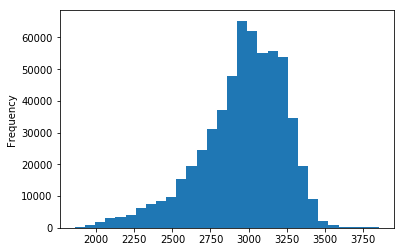

In [6]:
cover_data.Elevation.plot.hist(bins=30)

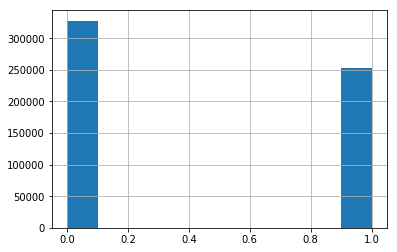

In [7]:
cover_data.WE2.hist()

In [8]:
cover_data.groupby('Cover').Cover.count() / cover_data.shape[0]

Cover
1    0.364605
2    0.487599
3    0.061537
4    0.004728
5    0.016339
6    0.029891
7    0.035300
Name: Cover, dtype: float64

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

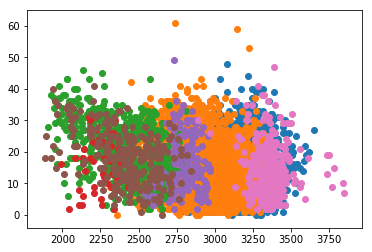

In [13]:
sample = cover_data.sample(10000)
for k, group in sample.groupby('Cover'):
    plt.scatter(group.Elevation, group.Slope)

In [4]:
import numpy as np

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train, test = train_test_split(cover_data, test_size=0.3)

In [7]:
means, pis, labels, Sigmas = [], [], [], []
N, p = train.shape
p -= 1
Sigma = np.zeros([p, p])
for label, data in train.groupby('Cover'):
    labels.append(label)
    Nk, _ = data.shape
    print Nk, N, label
    pis.append(Nk / float(N))
    mu = data.mean()
    means.append(mu[:-1])
    xn = (data - mu).values[:,:-1]
    S = np.zeros([p, p])
    for i in range(Nk):
        S += np.dot(xn[i:i+1,:].T, xn[i:i+1,:])
    Sigmas.append(S / (Nk - 1))
    Sigma += S
Sigma /= float(N - len(labels))

148128 406708 1
198555 406708 2
24950 406708 3
1897 406708 4
6681 406708 5
12233 406708 6
14264 406708 7


In [8]:
Sigmainv = np.linalg.inv(Sigma)

In [9]:
pis

[0.3642121620425465,
 0.48820037963354546,
 0.061346223826430755,
 0.004664280023997561,
 0.016427018893161678,
 0.030078090423596292,
 0.03507184515672178]

In [10]:
def delta(x, mu, pi):
    return (np.dot(np.dot(x, Sigmainv), mu)
            - 0.5 * np.dot(np.dot(mu.T, Sigmainv), mu)
            + np.log(pi))

In [11]:
def lda(x):
    return np.argmax(np.array([delta(x, mu, pi) for mu, pi in zip(means, pis)]).T, axis=1)

In [13]:
labels

[1, 2, 3, 4, 5, 6, 7]

In [12]:
(lda(test[column_names[:-1]]) + 1 == test.Cover).mean()

0.67785019276666059

In [15]:
for l, X in test.groupby('Cover'):
    print l, (lda(X[column_names[:-1]]) + 1 == l).mean(), float(len(X)) / len(test)

1 0.622030237581 0.363910179916
2 0.758796154841 0.488193042041
3 0.530822873082 0.061702542684
4 0.602853745541 0.00482490361667
5 0.225966654842 0.0161728933358
6 0.502992855764 0.029712456398
7 0.805658852061 0.0354839820084


In [130]:
Si = np.linalg.inv(0.5*Sigmas[0] + 0.5*Sigma)

In [123]:
def delta_r(x, mu, pi, logS, Sinv):
    return (-0.5 * logS
            - 0.5 * np.sum(np.dot((x-mu), Sinv) * (x-mu), axis=1)
            + np.log(pi))

In [235]:
def rda(x, alpha):
    Sigmas_r = [alpha*S + (1-alpha)*Sigma for S in Sigmas]
    eigs = [np.linalg.eig(S)[0] for S in Sigmas_r]
    logs = [np.sum(np.log(e[e>1e-12])) for e in eigs]
    Sinv_r = [np.linalg.inv(S) for S in Sigmas_r]
    vals = np.array([delta_r(x, mu, pi, logS, Sinv) for mu, pi, Sinv, logS 
                               in zip(means, pis, Sinv_r, logs)]).T
    return np.argmax(vals, axis=1)

In [236]:
(rda(test[column_names[:-1]], 0) + 1 == test.Cover).mean()

0.6795483752524325

In [237]:
(rda(test[column_names[:-1]], 0.8) + 1 == test.Cover).mean()

0.46829676886359461

In [238]:
for l, X in test.groupby('Cover'):
    print l, (rda(X[column_names[:-1]], 0.2) + 1 == l).mean(), float(len(X)) / len(test)

1 0.731487758352 0.363910179916
2 0.499882482901 0.488193042041
3 0.831427243143 0.061702542684
4 0.662306777646 0.00482490361667
5 0.530329904221 0.0161728933358
6 0.229774087662 0.029712456398
7 0.806305578011 0.0354839820084


In [239]:
for l, X in test.groupby('Cover'):
    print l, (rda(X[column_names[:-1]], 0.8) + 1 == l).mean(), float(len(X)) / len(test)

1 0.817612839148 0.363910179916
2 0.141984158695 0.488193042041
3 0.89669920967 0.061702542684
4 0.69322235434 0.00482490361667
5 0.733948208585 0.0161728933358
6 0.0558022784321 0.029712456398
7 0.824090541633 0.0354839820084


In [240]:
rs = np.arange(0.1, 1, 0.1)
hits = [(rda(test[column_names[:-1]], r) + 1 == test.Cover).mean() for r in rs]

In [189]:
import matplotlib.pyplot as plt
%matplotlib inline

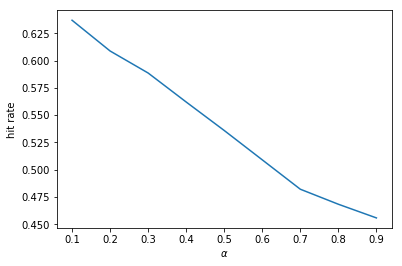

In [241]:
plt.plot(rs, hits)
plt.xlabel(r'$\alpha$')
plt.ylabel('hit rate')

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [32]:
sk_model = LinearDiscriminantAnalysis().fit(train[column_names[:-1]], train.Cover)

/home/dirk/Virtualenvs/std/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [34]:
sk_hits = sk_model.predict(test[column_names[:-1]]) == test.Cover

In [35]:
sk_hits.mean()

0.6804892601431981

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
import time

In [40]:
deltas = []
Ns = np.arange(1e4, 6e4, 1e4)
for N in Ns:
    X = train.sample(int(N))
    start = time.time()
    lr = LogisticRegression().fit(X[column_names[:-1]], X.Cover)
    deltas.append(time.time() - start)

In [41]:
deltasLDA = []
for N in Ns:
    X = train.sample(int(N))
    start = time.time()
    lda = LinearDiscriminantAnalysis().fit(X[column_names[:-1]], X.Cover)
    deltasLDA.append(time.time() - start)

/home/dirk/Virtualenvs/std/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


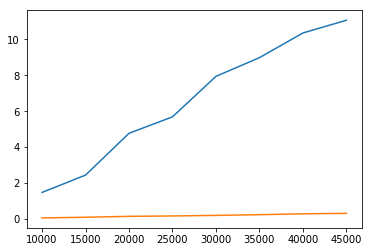

In [43]:
plt.plot(Ns, deltas)
plt.plot(Ns, deltasLDA)

## Maximizing log-likelihood

In [6]:
train.shape

(406708, 55)

In [31]:
reg_train = train.sample(15000)

In [32]:
from statsmodels.discrete.discrete_model import Logit

In [45]:
X, y = reg_train[column_names[:10]].copy(), (reg_train.Cover == 2) + 0.0

In [39]:
X['const'] = 1

In [40]:
model = Logit(y, X)

In [46]:
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.094309
         Iterations 10


In [47]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Cover   No. Observations:                15000
Model:                          Logit   Df Residuals:                    14989
Method:                           MLE   Df Model:                           10
Date:                Sat, 04 Mar 2017   Pseudo R-squ.:                  0.5804
Time:                        12:16:57   Log-Likelihood:                -1414.6
converged:                       True   LL-Null:                       -3371.4
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Elevation                             -0.0087      0.000    -28.411      0.000      -0.009      -0.008
Aspect                              3.969e-05      0.001      0.060      0.952      -0.001       0.001
Slope                                  0.0388      0.011      3.631      0.000       0.018       0.060
Horizontal_Distance_To_Hydrology       0.0023      0.000      5.736      0.000       0.002       0.003
Vertical_Distance_To_Hydrology         0.0055      0.001      4.993      0.000       0.003       0.008
Horizontal_Distance_To_Roadways       -0.0002   7.34e-05     -2.285      0.022      -0.000   -2.38e-05
Hillshade_9am                         -0.0246      0.008     -2.980      0.003      -0.041      -0.008
Hillshade_Noon                         0.0657      0.007      9.160      0.000       0.052       0.080
Hillshade_3pm                         -0.0337      0.007     -5.026      0.000      -0.047      -0.021
Horizontal_Distance_To_Fire_Points    -0.0004   7.38e-05     -5.351      0.000      -0.001      -0.000
const                                 15.4683      1.618      9.559      0.000      12.297      18.640
======================================================================================================
"""

In [52]:
import numpy as np

In [98]:
result.pred_table(0.2)

array([[ 13606.,    506.],
       [   170.,    718.]])

In [66]:
(y == 0).sum()

7649

In [67]:
(y == 1).sum()

7351

In [95]:
tpr, fpr = [], []
for i in np.arange(0,1,0.01):
    r = result.pred_table(i)
    tn = r[0,0]
    fn = r[1,0]
    fp = r[0,1]
    tp = r[1,1]
    tpr.append(tp / (tp + fn))
    fpr.append(fp /(fp + tn))

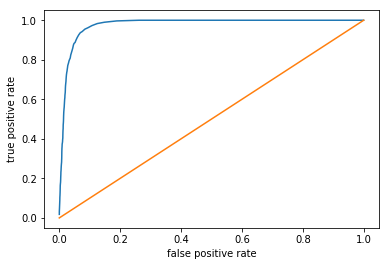

In [102]:
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.savefig('../08-classification/img/ROC.png', dpi=200)